In [173]:
import os
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from PIL import Image
import nrrd
from keras.preprocessing.image import array_to_img
from tensorflow.keras import layers
import random
import matplotlib.pyplot as plt
import io
import imageio
from IPython.display import Image, display

In [128]:
num_classes = 2

batch_size = 2

img_size= (64,64)

In [148]:
#Pick random train and val:
path= 'C:/Users/bvtran/OneDrive - Inside MD Anderson/Documents/MRL_data/RD_Center_cropped'
datadir= os.listdir(path)
remove=['2521725','2570357','2574697','2587907','895844','2547570']
for i in remove:
    datadir.remove(i)
train_dir=random.sample(datadir, 17)
for i in range(len(train_dir)):
    datadir.remove(train_dir[i])
val_dir=random.sample(datadir, 2)
train_path=[]
val_path=[]
for i in range(len(train_dir)):
    train_path.append(path+'/'+str(train_dir[i]))
for i in range(len(val_dir)):
    val_path.append(path+'/'+str(val_dir[i]))    
print("Number of train samples:", len(train_dir),": ",train_dir)
print("Number of test samples:", len(val_dir),": ",val_dir)

Number of train samples: 17 :  ['2609170', '2467000', '2459017', '2419611', '2413785', '2551521', '1049397', '2591335', '2541392', '2593206', '2386449', '2455275', '2139028', '2377620', '2510278', '862797', '2403028']
Number of test samples: 2 :  ['2604993', '2467929']


In [176]:
path= 'C:/Users/bvtran/OneDrive - Inside MD Anderson/Documents/MRL_data/RD_Center_cropped'
datadir= os.listdir(path)
remove=['2521725','2570357','2574697','2587907','895844','2547570','2377620', '2459017']
for i in remove:
    datadir.remove(i)
train_dir=random.sample(datadir, 15)
for i in range(len(train_dir)):
    datadir.remove(train_dir[i])
val_dir=['2377620', '2459017']
train_path=[]
val_path=[]
for i in range(len(train_dir)):
    train_path.append(path+'/'+str(train_dir[i]))
for i in range(len(val_dir)):
    val_path.append(path+'/'+str(val_dir[i]))    
print("Number of train samples:", len(train_dir),": ",train_dir)
print("Number of test samples:", len(val_dir),": ",val_dir)

Number of train samples: 15 :  ['2467000', '2609170', '2139028', '1049397', '862797', '2467929', '2403028', '2593206', '2386449', '2591335', '2551521', '2455275', '2510278', '2419611', '2541392']
Number of test samples: 2 :  ['2377620', '2459017']


In [5]:
from scipy.ndimage import zoom


def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [147]:
#Prepare sequence class to load and vectorize batches of data

class tumorMaskData(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,))
        for j, path in enumerate(batch_input_img_paths):
            data_path= os.listdir(path)
            Contour_path=[]
            for i in range(len(data_path)):
                if ("Contour" in data_path[i])==True:
                    Contour_path.append(data_path[i]) 
            contour1, header = nrrd.read(path+'/'+Contour_path[0])
            contour2, header = nrrd.read(path+'/'+Contour_path[1])
            contour3, header = nrrd.read(path+'/'+Contour_path[2])
#             if ("2547570" in path)==False:
            contour1 = clipped_zoom(contour1, 2)
            contour2 = clipped_zoom(contour2, 2)
            contour3 = clipped_zoom(contour3, 2)
            x[j] = np.stack((contour1*255,contour2*255,contour3*255), axis=-1)
            
        y = np.zeros((self.batch_size,) + self.img_size + (1,))
        for j, path in enumerate(batch_target_img_paths):
            data_path= os.listdir(path)
            Contour_path=[]
            for i in range(len(data_path)):
                if ("Contour" in data_path[i])==True:
                    Contour_path.append(data_path[i])
            contour, header = nrrd.read(path+'/'+Contour_path[-1])
#             if ("2547570" in path)==False:
            contour = clipped_zoom(contour, 2)
            y[j] =np.expand_dims(contour, 2)
            
        return x, y
    

In [121]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [179]:
# Instantiate data Sequences for each split
train_gen = tumorMaskData(batch_size, img_size, train_path, train_path)
val_gen = tumorMaskData(batch_size, img_size, val_path, val_path)

In [190]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=1)

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen,callbacks=[early_stopping, reduce_lr])

Epoch 1/15
7/7 [==============================] - 2s 220ms/step - loss: 0.4987 - val_loss: 0.3817
Epoch 2/15
7/7 [==============================] - 1s 116ms/step - loss: 0.1388 - val_loss: 0.1122
Epoch 3/15
7/7 [==============================] - 1s 117ms/step - loss: 0.0542 - val_loss: 0.0729
Epoch 4/15
7/7 [==============================] - 1s 115ms/step - loss: 0.0399 - val_loss: 0.0699
Epoch 5/15
7/7 [==============================] - 1s 120ms/step - loss: 0.0750 - val_loss: 0.0671
Epoch 6/15
7/7 [==============================] - 1s 114ms/step - loss: 0.0773 - val_loss: 0.1958
Epoch 7/15
7/7 [==============================] - 1s 124ms/step - loss: 0.0645 - val_loss: 0.0903
Epoch 8/15
7/7 [==============================] - 1s 114ms/step - loss: 0.0359 - val_loss: 0.0855
Epoch 9/15
7/7 [==============================] - 1s 115ms/step - loss: 0.0347 - val_loss: 0.0835
Epoch 10/15
7/7 [==============================] - 1s 120ms/step - loss: 0.0346 - val_loss: 0.0822
Epoch 11/15
7/7 [==

In [191]:
#Generate predictions for all images in the validation set
val_preds = model.predict(val_gen)

In [186]:
model.save('C:/Users/bvtran/OneDrive - Inside MD Anderson/Documents/MRL_data/python_code/Unet-Contour')

INFO:tensorflow:Assets written to: C:/Users/bvtran/OneDrive - Inside MD Anderson/Documents/MRL_data/python_code/Unet-Contour\assets


In [97]:
model = keras.models.load_model('C:/Users/bvtran/OneDrive - Inside MD Anderson/Documents/MRL_data/python_code')

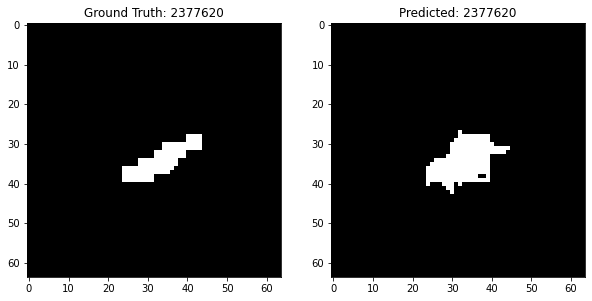

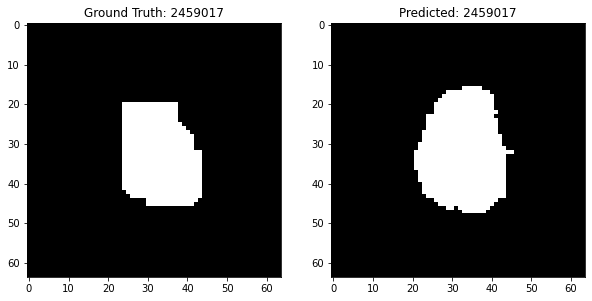

In [192]:
mask_predict=[]
mask_gt=[]
for i in range(len(val_dir)):
    original_frames= val_gen[0][1][i]
    original_frame=np.squeeze(original_frames)
    mask_gt.append(original_frame)
    predicted_frame= np.argmax(val_preds[i], axis=-1)
    mask_predict.append(predicted_frame)
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    axes[0].imshow(original_frame, cmap="gray")
    axes[0].set_title(f"Ground Truth: {val_dir[i]}")
    axes[1].imshow(predicted_frame, cmap="gray")
    axes[1].set_title(f"Predicted: {val_dir[i]}")
    plt.show()

In [183]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice

In [193]:
dice=[]
for i in range(2):
    dice.append(DICE_COE(mask_gt[i],mask_predict[i]))
dice

[0.689, 0.865]

In [188]:
np.array(mask_predict).shape

(2, 64, 64)

In [194]:
nrrd.write("Unet_predictions",np.array(mask_predict))